##  Abalone Age Prediction
Description- Predicting the age of abalone from physical measurements. The age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope -- a boring and time-consuming task. Other measurements, which are easier to obtain, are used to predict the age. Further information, such as weather patterns and location (hence food availability) may be required to solve the problem. 

In this article I have focussed on exploratory data analysis on Abalone Dataset. 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
%matplotlib inline

from sklearn.preprocessing import  StandardScaler
from sklearn.model_selection import  train_test_split, cross_val_score
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import  RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import  GradientBoostingRegressor
from sklearn.linear_model import  Ridge
from sklearn.svm import SVR
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import os
print(os.listdir("../input"))

['abalone.csv']


In [2]:
# Read the dataset 
data = pd.read_csv('../input/abalone.csv')

From problem statement and feature discription, let's first compute the target varible of the problem ' Age' and assign it to the dataset. 
Age = 1.5+Rings

In [3]:
 data['age'] = data['Rings']+1.5
 data.drop('Rings', axis = 1, inplace = True)

## Univariate analysis
Understanding feature wise statistics using various inbuilt tools 

In [4]:
print('This dataset has {} observations with {} features.'.format(data.shape[0], data.shape[1]))

This dataset has 4177 observations with 9 features.


In [5]:
data.columns

Index(['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight',
       'Viscera weight', 'Shell weight', 'age'],
      dtype='object')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
Sex               4177 non-null object
Length            4177 non-null float64
Diameter          4177 non-null float64
Height            4177 non-null float64
Whole weight      4177 non-null float64
Shucked weight    4177 non-null float64
Viscera weight    4177 non-null float64
Shell weight      4177 non-null float64
age               4177 non-null float64
dtypes: float64(8), object(1)
memory usage: 293.8+ KB


In [7]:
data.describe()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,age
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,11.433684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,2.500000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,9.500000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,10.500000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,12.500000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,30.500000


Key insights : 
            - No missing values in the dataset
            - All numerical features but 'sex'
            - Though features are not normaly distributed, are close to normality
            - None of the features have minimum = 0 except Height (requires re-check)
            - Each feature has difference scale range

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f065fbf5278>,
      dtype=object)

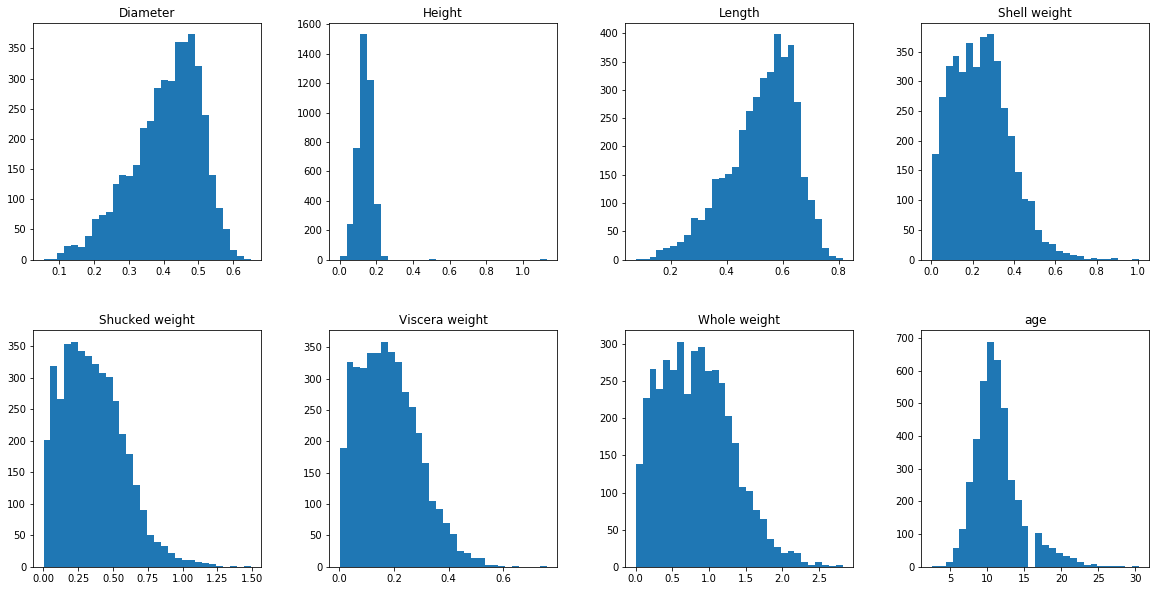

In [8]:
data.hist(figsize=(20,10), grid=False, layout=(2, 4), bins = 30)

In [9]:
numerical_features = data.select_dtypes(include=[np.number]).columns
categorical_features = data.select_dtypes(include=[np.object]).columns

In [10]:
numerical_features

Index(['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight',
       'Viscera weight', 'Shell weight', 'age'],
      dtype='object')

In [11]:
categorical_features

Index(['Sex'], dtype='object')

In [12]:
skew_values = skew(data[numerical_features], nan_policy = 'omit')
dummy = pd.concat([pd.DataFrame(list(numerical_features), columns=['Features']), 
           pd.DataFrame(list(skew_values), columns=['Skewness degree'])], axis = 1)
dummy.sort_values(by = 'Skewness degree' , ascending = False)

,Features,Skewness degree
2,Height,3.127694
7,age,1.113702
4,Shucked weight,0.718840
6,Shell weight,0.620704
5,Viscera weight,0.591640
3,Whole weight,0.530768
1,Diameter,-0.608979
0,Length,-0.639643


For normally distributed data, the skewness should be about 0. For unimodal continuous distributions, a skewness value > 0 means that there is more weight in the right tail of the distribution. The function skewtest can be used to determine if the skewness value is close enough to 0, statistically speaking.
        - Height has highest skewedness followed by age, Shucked weight (can be cross verified through histogram plot)

In [13]:
# Missing values
missing_values = data.isnull().sum().sort_values(ascending = False)
percentage_missing_values = (missing_values/len(data))*100
pd.concat([missing_values, percentage_missing_values], axis = 1, keys= ['Missing values', '% Missing'])

,Missing values,% Missing
age,0,0.0
Shell weight,0,0.0
Viscera weight,0,0.0
Shucked weight,0,0.0
Whole weight,0,0.0
Height,0,0.0
Diameter,0,0.0
Length,0,0.0
Sex,0,0.0


No missing values as said before

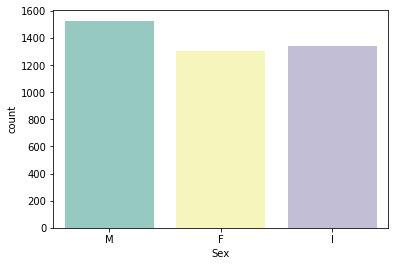

In [14]:
sns.countplot(x = 'Sex', data = data, palette="Set3")

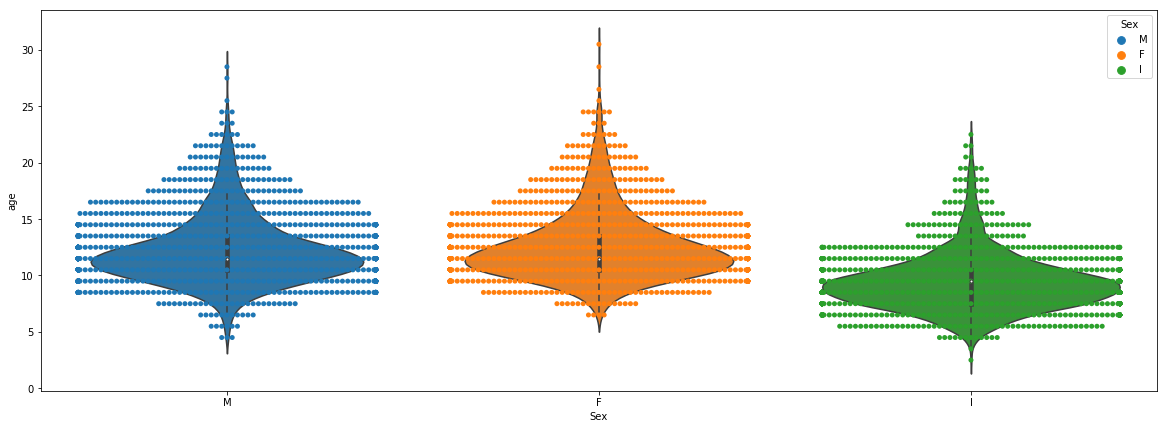

In [15]:
plt.figure(figsize = (20,7))
sns.swarmplot(x = 'Sex', y = 'age', data = data, hue = 'Sex')
sns.violinplot(x = 'Sex', y = 'age', data = data)

        Male : age majority lies in between 7.5 years to 19 years
        Female: age majority lies in between 8 years to 19 years
        Immature: age majority lies in between 6 years to < 10 years

In [16]:
data.groupby('Sex')[['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight',
       'Viscera weight', 'Shell weight', 'age']].mean().sort_values('age')

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,age
Sex,,,,,,,,
I,0.427746,0.326494,0.107996,0.431363,0.191035,0.092010,0.128182,9.390462
M,0.561391,0.439287,0.151381,0.991459,0.432946,0.215545,0.281969,12.205497
F,0.579093,0.454732,0.158011,1.046532,0.446188,0.230689,0.302010,12.629304


## Bivariate Analysis
Bivariate analysis is vital part of data analysis process for, it gives clear picture on how each features are affected in presence of other features.  
It also helps us understand and identify significance features, overcome multi-collinearity effect, inter-dependency and thus, provides insights on hidden data noise pattern.

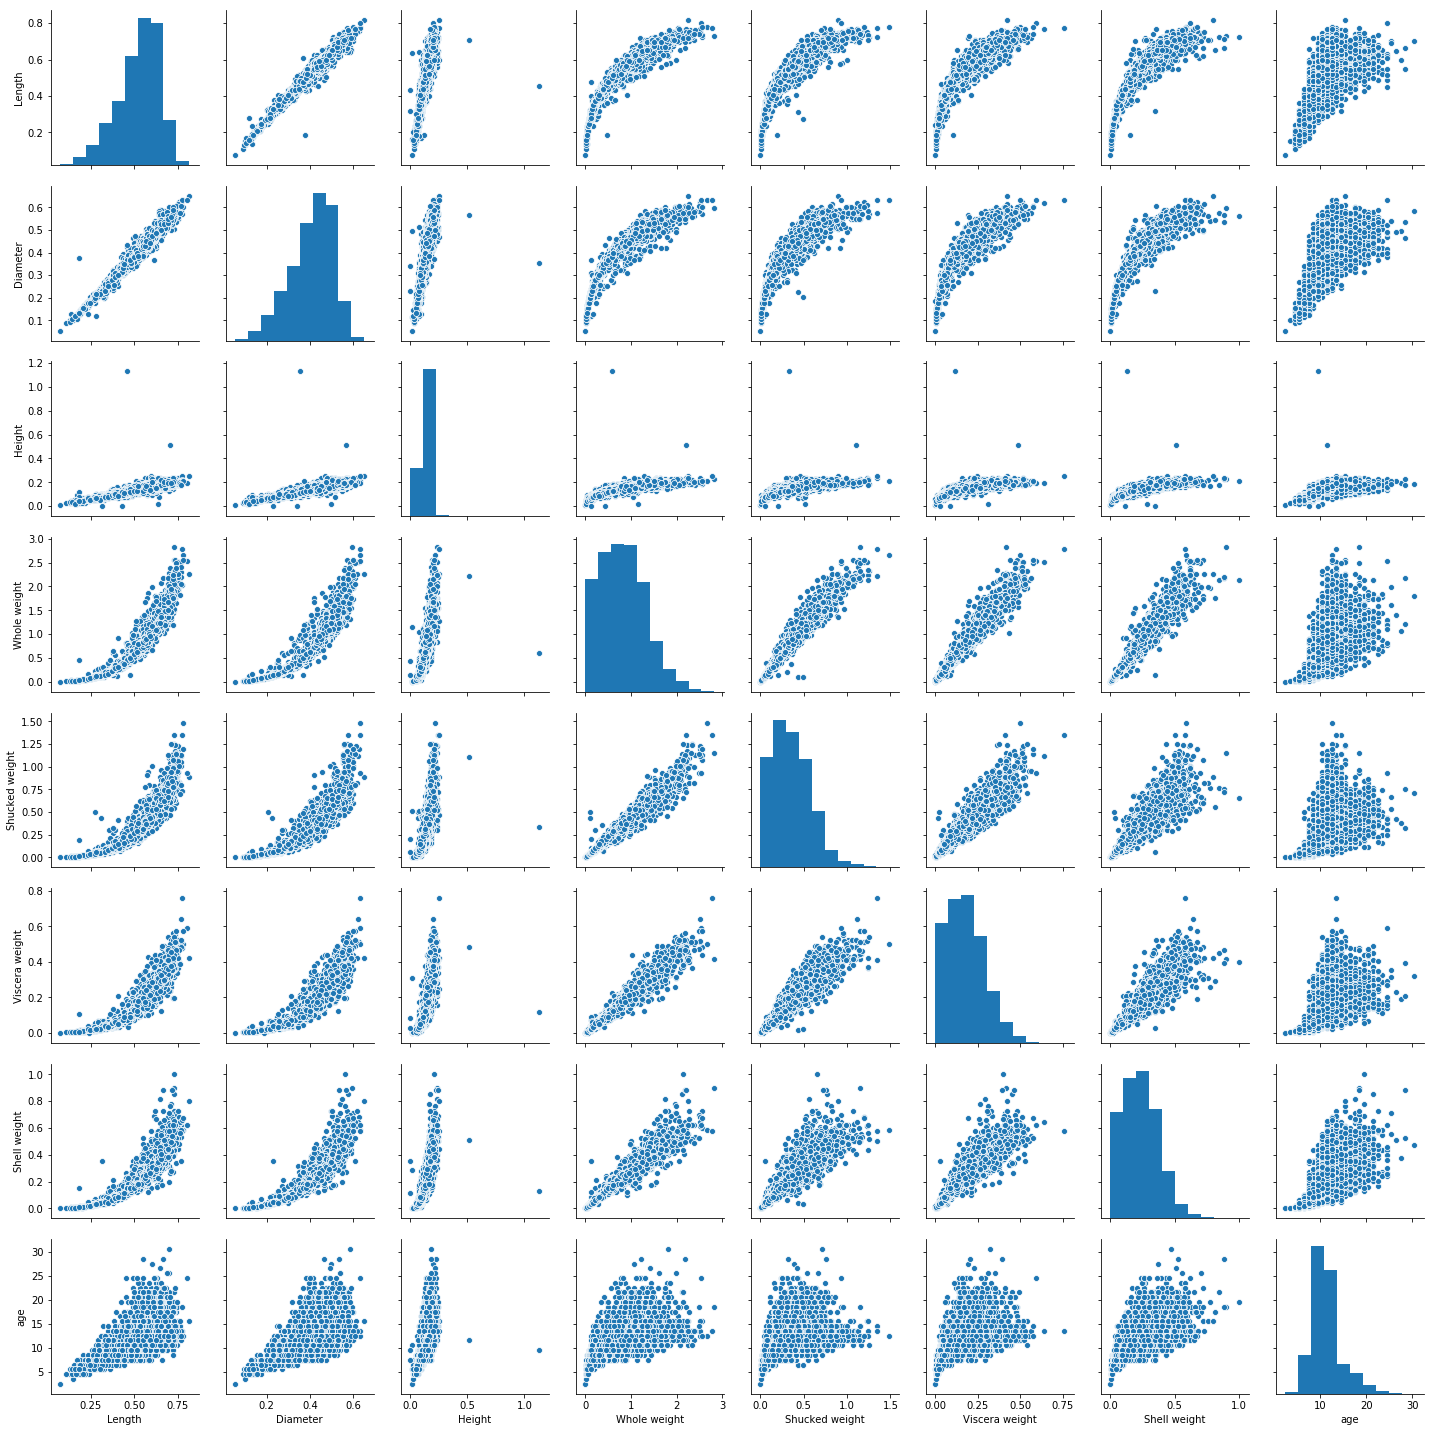

In [17]:
sns.pairplot(data[numerical_features])

key insights
            length is linearly correlated with diameter while, non-linear relation with height, whole weight, shucked weight, viscera weight and shell weight
        
        

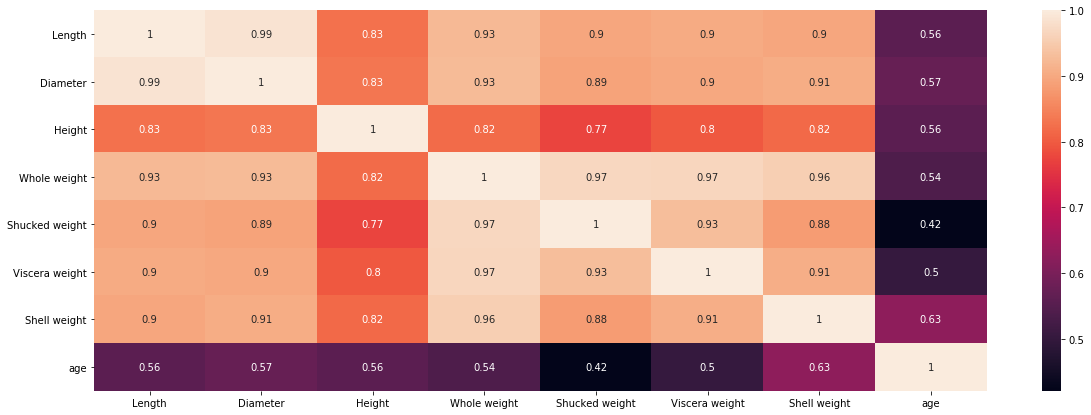

In [18]:
plt.figure(figsize=(20,7))
sns.heatmap(data[numerical_features].corr(), annot=True)

        Whole Weight is almost linearly varying with all other features except age
        Heigh has least linearity with remaining features
        Age is most linearly proprtional with Shell Weight followed by Diameter and length
        Age is least correlated with Shucked Weight
        
  Such high correlation coefficients among features can result into multi-collinearity. We need to check for that too, however, I have not done it here.

## Outliers handlings

In [19]:
data = pd.get_dummies(data)
dummy_data = data.copy()

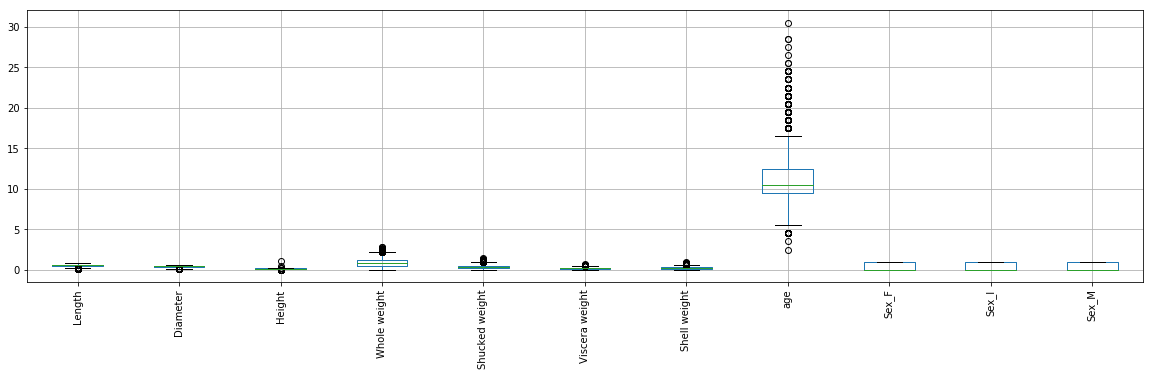

In [20]:
data.boxplot( rot = 90, figsize=(20,5))

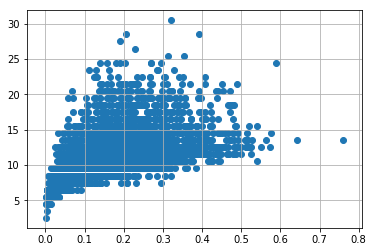

In [21]:
var = 'Viscera weight'
plt.scatter(x = data[var], y = data['age'],)
plt.grid(True)

In [22]:
# outliers removal
data.drop(data[(data['Viscera weight']> 0.5) & (data['age'] < 20)].index, inplace=True)
data.drop(data[(data['Viscera weight']<0.5) & (data['age'] > 25)].index, inplace=True)

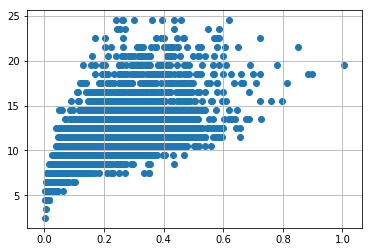

In [23]:
var = 'Shell weight'
plt.scatter(x = data[var], y = data['age'],)
plt.grid(True)

In [24]:
data.drop(data[(data['Shell weight']> 0.6) & (data['age'] < 25)].index, inplace=True)
data.drop(data[(data['Shell weight']<0.8) & (data['age'] > 25)].index, inplace=True)

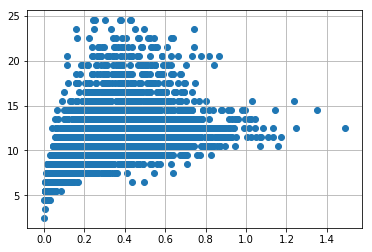

In [25]:
var = 'Shucked weight'
plt.scatter(x = data[var], y = data['age'],)
plt.grid(True)

In [26]:
data.drop(data[(data['Shucked weight']>= 1) & (data['age'] < 20)].index, inplace=True)
data.drop(data[(data['Shucked weight']<1) & (data['age'] > 20)].index, inplace=True)

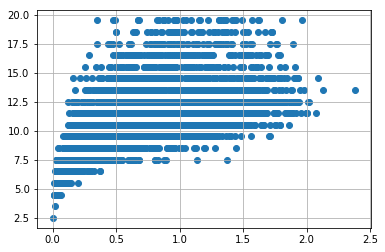

In [27]:
var = 'Whole weight'
plt.scatter(x = data[var], y = data['age'],)
plt.grid(True)

In [28]:
data.drop(data[(data['Whole weight']>= 2.5) & (data['age'] < 25)].index, inplace=True)
data.drop(data[(data['Whole weight']<2.5) & (data['age'] > 25)].index, inplace=True)

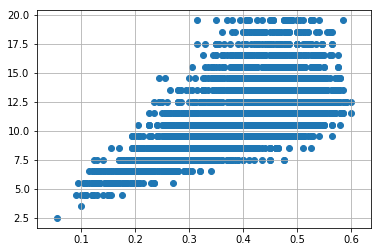

In [29]:
var = 'Diameter'
plt.scatter(x = data[var], y = data['age'],)
plt.grid(True)

In [30]:
data.drop(data[(data['Diameter']<0.1) & (data['age'] < 5)].index, inplace=True)
data.drop(data[(data['Diameter']<0.6) & (data['age'] > 25)].index, inplace=True)
data.drop(data[(data['Diameter']>=0.6) & (data['age']< 25)].index, inplace=True)

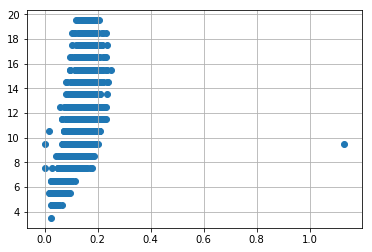

In [31]:
var = 'Height'
plt.scatter(x = data[var], y = data['age'],)
plt.grid(True)

In [32]:
data.drop(data[(data['Height']>0.4) & (data['age'] < 15)].index, inplace=True)
data.drop(data[(data['Height']<0.4) & (data['age'] > 25)].index, inplace=True)

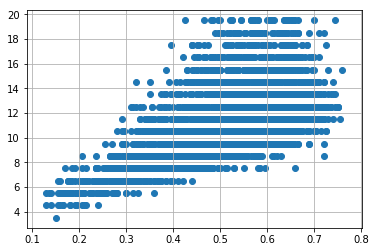

In [33]:
var = 'Length'
plt.scatter(x = data[var], y = data['age'],)
plt.grid(True)

In [34]:
data.drop(data[(data['Length']<0.1) & (data['age'] < 5)].index, inplace=True)
data.drop(data[(data['Length']<0.8) & (data['age'] > 25)].index, inplace=True)
data.drop(data[(data['Length']>=0.8) & (data['age']< 25)].index, inplace=True)

## Preprocessing, Modeling, Evaluation
The base steps followed in any data modeling pipelines are:
               - pre-processing 
               - suitable model selection
               - modeling
               - hyperparamaters tunning using GridSearchCV
               - evaluation

In [35]:
X = data.drop('age', axis = 1)
y = data['age']

In [36]:
standardScale = StandardScaler()
standardScale.fit_transform(X)

selectkBest = SelectKBest()
X_new = selectkBest.fit_transform(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size = 0.25)

In [37]:
np.random.seed(10)
def rmse_cv(model, X_train, y):
    rmse =- (cross_val_score(model, X_train, y, scoring='neg_mean_squared_error', cv=5))
    return(rmse*100)

models = [LinearRegression(),
             Ridge(),
             SVR(),
             RandomForestRegressor(),
             GradientBoostingRegressor(),
             KNeighborsRegressor(n_neighbors = 4),]

names = ['LR','Ridge','svm','GNB','RF','GB','KNN']

for model,name in zip(models,names):
    score = rmse_cv(model,X_train,y_train)
    print("{}    : {:.6f}, {:4f}".format(name,score.mean(),score.std()))

LR    : 355.566707, 10.743700
Ridge    : 361.241751, 9.998595


/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default 

svm    : 434.124845, 17.725957


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

GNB    : 379.103827, 24.955995
RF    : 342.223096, 19.874296
GB    : 387.159137, 10.911615


You have seen the perofrmance of each one of above models.

So, according to you which model should we start or choose?
Well the answer lies in Occam's razor principle from philosophy https://simple.wikipedia.org/wiki/Occam%27s_razor." Suppose there exist two explanations for an occurrence. In this case the simpler one is usually better. Another way of saying it is that the more assumptions you have to make, the more unlikely an explanation."
Hence, starting with the simplest model Ridge, for various reasons:
            - Feature Dimension is less
            - No misisng values
            - Few categorical features

In [38]:

def modelfit(alg, dtrain, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['age'])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    #dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = -cross_val_score(alg, dtrain[predictors], dtrain['age'], cv=cv_folds, 
                                                    scoring='r2')
    
    #Print model report:
    print ("\nModel Report")
    print( "RMSE : %.4g" % mean_squared_error(dtrain['age'].values, dtrain_predictions))
    print( "R2 Score (Train): %f" % r2_score(dtrain['age'], dtrain_predictions))
    
    if performCV:
        print( "CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),
                                                                                 np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.coef_, predictors).sort_values(ascending=False)
        plt.figure(figsize=(20,4))
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')


Model Report
RMSE : 3.593
R2 Score (Train): 0.529894
CV Score : Mean - -0.4503433 | Std - 0.08079434 | Min - -0.514565 | Max - -0.3061263


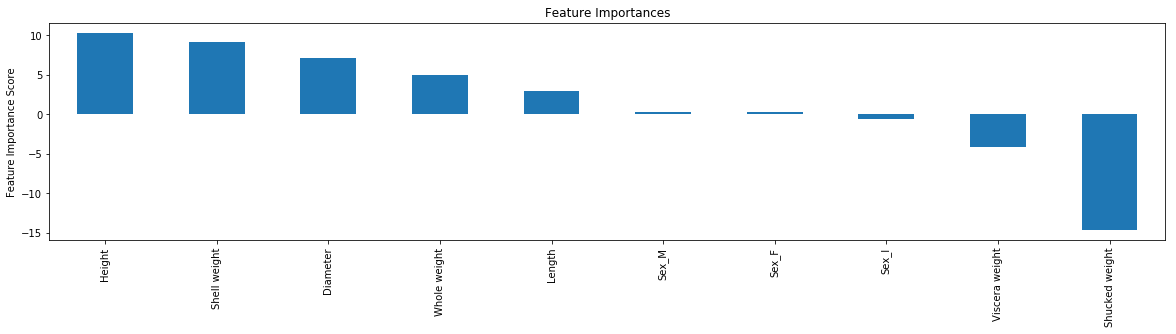

In [39]:
# Base Model
predictors = [x for x in data.columns if x not in ['age']]
lrm0 = Ridge(random_state=10)
modelfit(lrm0, data, predictors)

## Hyperparameter tunning using GrideSearchCV

In [40]:
# Let's do hyperparameter tunning using GrideSearchCV
from sklearn.model_selection import  GridSearchCV
param  = {'alpha':[0.01, 0.1, 1,10,100],
         'solver' : ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}
glrm0 = GridSearchCV(estimator = Ridge(random_state=10,),
param_grid = param,scoring= 'r2' ,cv = 5,  n_jobs = -1)
glrm0.fit(X_train, y_train)
glrm0.best_params_, glrm0.best_score_

({'alpha': 0.01, 'solver': 'saga'}, 0.5378297745778723)


Model Report
RMSE : 3.558
R2 Score (Train): 0.534426
CV Score : Mean - -0.4543985 | Std - 0.08665801 | Min - -0.5172686 | Max - -0.2913273


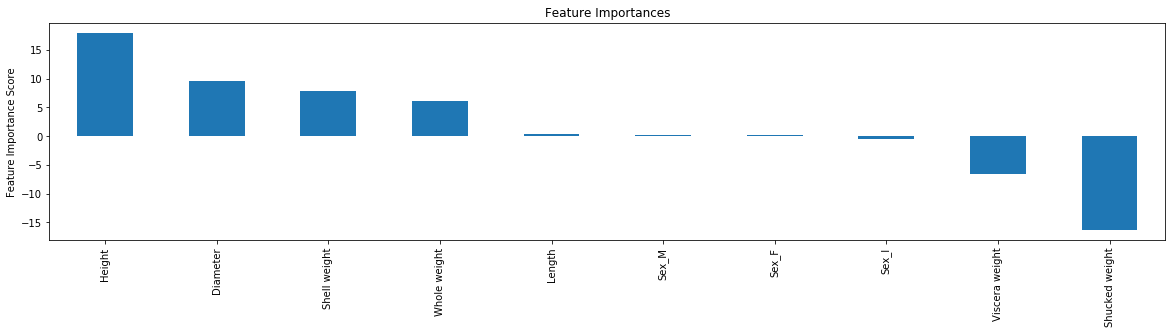

In [41]:
modelfit(Ridge(alpha = 0.1,random_state=10,), data, predictors)

CV score has improved slightly while, R2_score has decreased showing base model was overfitted.
Using above process multiple options can be tried to could up with much more robust model.
This process can also be tried on different models : RF, GB, etc.

Hyperparameter tunning is an iterative process and it can go on. As this kernal primary focuses on EDA of Abalone dataset, modeling building will be taken into another kernal ["Modeling - Abalone Age Prediction" ]. Hope I have helped you getting insights of Abalone dataset through this kernal.

Motivate me so that I will come up soon with  "Modeling - Abalone Age Prediction" . :)